# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

import mlflow
import mlflow.sklearn

from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import(
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report,
                              confusion_matrix,
                              accuracy_score,
                              ConfusionMatrixDisplay,
                              roc_auc_score,
                              RocCurveDisplay,
                              precision_score,
                              recall_score)
from sklearn.model_selection import KFold,train_test_split,ParameterGrid

d:\Romario\Programar\Ferramentas\Python\mlops\chronic\venv\Lib\site-packages\pydantic\_internal\_fields.py:128: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
d:\Romario\Programar\Ferramentas\Python\mlops\chronic\venv\Lib\site-packages\pydantic\_internal\_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


# Import Dataset

In [3]:
data=pd.read_csv('../data/stroke_impute_data.csv')

# Split Dataset

In [4]:
X=data.drop('stroke',axis=1)
y=data['stroke']

# Cross Validation

In [5]:
sgk = KFold(n_splits=5,shuffle=True,random_state=42)

# Configure Models

In [ ]:
models = {
                "Random_Forest": RandomForestClassifier(random_state=42),
                "Decision_Tree": DecisionTreeClassifier(random_state=42),
                "Gradient_Boosting": GradientBoostingClassifier(random_state=42),
                "Logistic_Regression": LogisticRegression(random_state=42),
                "XGBClassifier": XGBClassifier(),
                "AdaBoost_Classifier": AdaBoostClassifier(random_state=42,),
                "SVM_Classifier":svm.SVC(random_state=42,)
            }
params={
                "Decision_Tree": {
                    'criterion':['gini', 'log_loss', 'entropy'],
                    'max_features':['auto', 'sqrt', 'log2'],
                    'max_depth' : [3,5,10]

                },
                "Random_Forest":{                    
                    'n_estimators': [8,16,32],
                    'criterion':['gini','entropy','log_loss'],
                    'max_depth' : [3,5,10],

                },
                "Gradient_Boosting":{
                    'learning_rate':[.1,.01,.05,.001],
                    'n_estimators': [8,16,32],
                    'loss' : ['log_loss'],
                    'max_depth' : [3,5,10],
                },

               "Logistic_Regression":{
                   'penalty' : ['l1', 'l2', 'elasticnet', None],
                    'C':[1,2,5],

               },
                "XGBClassifier":{
                    'learning_rate':[.1,.01,.05,.001],
                    'n_estimators': [8,16,32]
                },
                "AdaBoost_Classifier":{
                    'learning_rate':[.1,.01,0.5,.001],
                    'n_estimators': [8,16,32]
                },
                "SVM_Classifier":{
                     'C':[1,2,5],
                     'kernel' : ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
                }
                
            }


In [ ]:
caminho_pasta=f'Kfold_experiments_stroke_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}'
os.makedirs(caminho_pasta,exist_ok=True)
os.environ['MLFLOW_ARTIFACT_ROOT']=caminho_pasta
mlflow.set_experiment('K_Fold_Experimental_stroke')

In [10]:
for i in range(len(list(models))):
    model=list(models.values())[i]
    model_name=list(models.keys())[i]

    print(f'------------------Trainning {model_name} Model--------------------')
    model_params=params.get(model_name,{})
    param_grid=list(ParameterGrid(model_params))
    loop=0
    for params_combination in param_grid:
        loop +=1
        try:
            with mlflow.start_run():
                j=1

                metrics_acc=[]
                metrics_auc=[]
                metrics_pred_0=[]
                metrics_pred_1=[]
                metrics_recall_0=[]
                metrics_recall_1=[]

                for train_id,test_id in sgk.split(X):
                    mlflow.log_param('model',model_name)
                    mlflow.log_params(params_combination)
                    print(f'{model_name} Fold {j}:')

                    X_val=X.iloc[test_id]
                    y_val=y.iloc[test_id]

                    X_train=X.iloc[train_id]
                    y_train=y.iloc[train_id]

                    model.set_params(**params_combination) 
                    model.fit(X_train,y_train)

                    pred=model.predict(X_val)

                    acc_score=accuracy_score(y_val,pred)
                    metrics_acc.append(acc_score)

                    auc_score= roc_auc_score(y_val,pred)
                    metrics_auc.append(auc_score)

                    precision0=precision_score(y_val, pred, average='binary',pos_label=0)
                    metrics_pred_0.append(precision0)

                    precision1=precision_score(y_val, pred, average='binary',pos_label=1)
                    metrics_pred_1.append(precision1)


                    recall0=recall_score(y_val,pred,average='binary',pos_label=0)
                    metrics_recall_0.append(recall0)

                    recall1=recall_score(y_val,pred,average='binary',pos_label=1)
                    metrics_recall_1.append(recall1)                    
                    j+=1
                
                mlflow.log_metric("acc_score",np.mean(metrics_acc))
                mlflow.log_metric("AUC Score",np.mean(metrics_auc))
                mlflow.log_metric(f"Precision Score 0",np.mean(metrics_pred_0))
                mlflow.log_metric(f"Precision Score 1",np.mean(metrics_pred_1))
                mlflow.log_metric(f"Recall Score 0",np.mean(metrics_recall_0))
                mlflow.log_metric(f"Recall Score 1",np.mean(metrics_recall_1))          

                mlflow.end_run()
                            
        except Exception as e:
            log_print=f'Error in{model_name} with prameter: {params_combination}: {str(e)}'
            print(log_print)

SVM_Classifier Fold 2:
SVM_Classifier Fold 3:
SVM_Classifier Fold 4:
SVM_Classifier Fold 5:


# Model Training Tracking

In [8]:
model=GradientBoostingClassifier(learning_rate=0.1,loss='log_loss',max_depth=10,n_estimators=32)

In [9]:
caminho_pasta='Stroke_Model'
os.makedirs(caminho_pasta,exist_ok=True)
os.environ['MLFLOW_ARTIFACT_ROOT']=caminho_pasta
mlflow.set_experiment(caminho_pasta)

2023/10/25 17:02:32 INFO mlflow.tracking.fluent: Experiment with name 'Stroke_Model' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///d:/Romario/Programar/Ferramentas/Python/mlops/chronic/notebook/mlruns/607110502964557430', creation_time=1698264152957, experiment_id='607110502964557430', last_update_time=1698264152957, lifecycle_stage='active', name='Stroke_Model', tags={}>

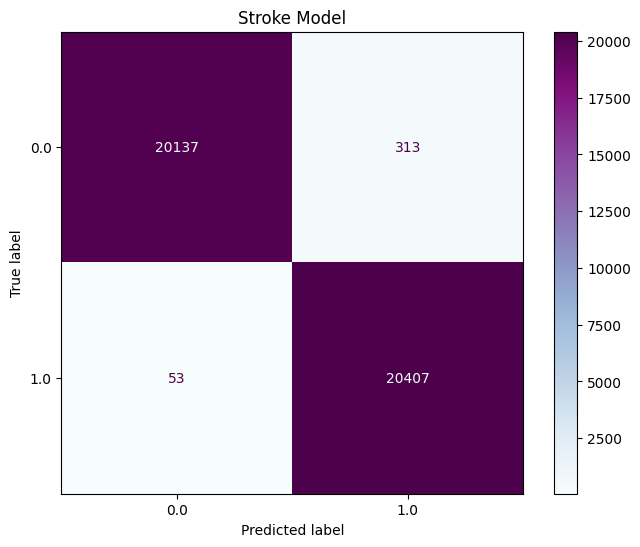

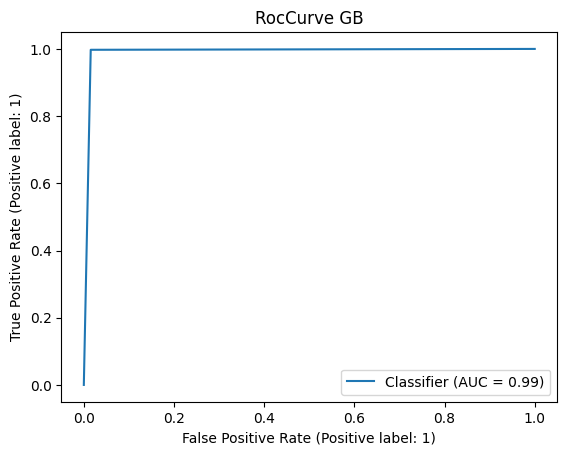

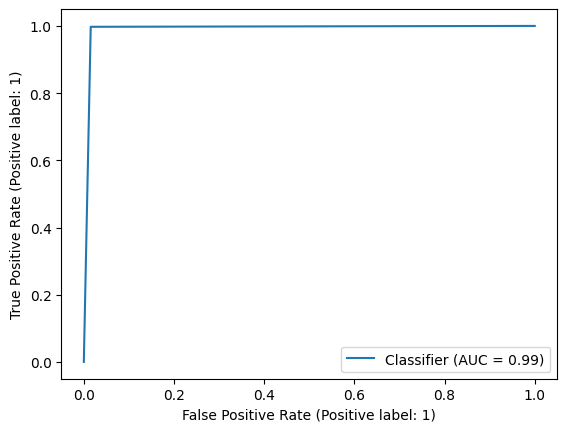

In [10]:
try:
            with mlflow.start_run():
                    model.fit(X,y)
                    mlflow.sklearn.log_model(model,caminho_pasta)

                    pred=model.predict(X)

                    acc_score=accuracy_score(y,pred)
                    mlflow.log_metric("acc_score",acc_score)

                    auc_score= roc_auc_score(y,pred)
                    mlflow.log_metric("AUC Score",auc_score)

                    precision0=precision_score(y, pred, average='binary',pos_label=0)                    
                    precision1=precision_score(y, pred, average='binary',pos_label=1)
                    

                    recall0=recall_score(y,pred,average='binary',pos_label=0)                  
                    recall1=recall_score(y,pred,average='binary',pos_label=1)               
                
                    mlflow.log_metric(f"Precision Score 0",precision0)
                    mlflow.log_metric(f"Precision Score 1",precision1)
                    mlflow.log_metric(f"Recall Score 0",recall0)
                    mlflow.log_metric(f"Recall Score 1",recall1)   

                    report_testing = classification_report(y, pred, output_dict=True)
                    df_report_testing = pd.DataFrame(report_testing).transpose()

                    artifact_path=os.path.join(caminho_pasta,f'report_testing.csv')        
                    df_report_testing.to_csv(artifact_path)
                    mlflow.log_artifact(artifact_path)

                    cm=confusion_matrix(y,pred,labels=model.classes_)
                    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
                    fig, ax = plt.subplots(figsize=(8, 6))
                    disp.plot(ax=ax, values_format='d', cmap='BuPu')
                    ax.set_title(f'Stroke Model')

                    artifact_path=os.path.join(caminho_pasta,"_conf_matrix.png")
                    plt.savefig(artifact_path)
                    mlflow.log_artifact(artifact_path)

                    
                    display=RocCurveDisplay.from_predictions(y,pred)
                    plt.title("RocCurve GB")
                    display.plot()
                    artifact_path=os.path.join(caminho_pasta,"roc_curve.png")
                    plt.savefig(artifact_path)
                    mlflow.log_artifact(artifact_path)
                          

                    mlflow.end_run()
                            
except Exception as e:
            log_print=f'Error in training GB'
            print(log_print)